In [1]:
using Pkg,Statistics,Random,Printf,GZip,Knet,Plots,LinearAlgebra,Distributions,StatsBase, Interact

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-16329486433730245162\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-1078904356962707961\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        require([\"/assetserver/6cbf0fd219fa6416ec9b47399ab16ea685b891e3-dist/main.js\"], function (webIOModule) {\n            webIOModule.load_ipython_extension();\n        });\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<div\n    id=\"webio-warning-16329486433730245162\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    <!-- TODO: link to installation docs. -->\n</div>\n")

## Generate training data

In [2]:
Random.seed!(1);
Range=3.0; # range of the x values for the target Gaussian function
Incr = 0.03; # Number of training examples = 3.0/0.03 = 100
Noise_std=0.1; # add noise on the Gaussian function

In [3]:
# generate the data from which we'll learn the Gaussian function
# obligatory arguments listed before ";" while optional arguments come after ";".
function gen_noisy_gaussian(;range=1.0,noise=0.1)
    x = collect(-Range:Incr:Range)
    y = exp.(-x.^2) + randn(length(x))*noise; # additive gaussian noise
    return (x,y)
end
# output is two vectors x,y

gen_noisy_gaussian (generic function with 1 method)

In [4]:
(x_train,y_train) = gen_noisy_gaussian(range=Range,noise=Noise_std);
pop!(x_train);pop!(y_train);

In [5]:
Ntrain =length(x_train) # number of training data points

200

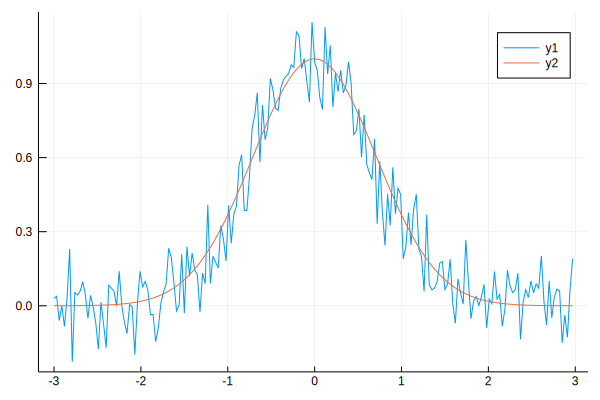

In [6]:
plot(x_train,[y_train,exp.(-x_train.^2)])

## Network + loss function

In [7]:
Batchsize = 10; # determines the degree of batch noise (smaller batchsize => larger noise)
RegWeight=0.001; # lambda for L2 regularization - sets the minimum of the Hessian eigenvalues
InitNorm = 0.5; # initial weight norm - not critical

In [8]:
Nweights = 7

7

In [9]:
function predict(w,x) # returns a row of predicted values for each sample in x
    return w[5:6]'*tanh.(w[1:2]*x' .+ w[3:4]) .+ w[7]
end

predict (generic function with 1 method)

In [10]:
# both x and y are ordered in columns per training data point
function sqloss(w,x,y)
    return mean(abs2,y'-predict(w,x))
end

function reg(w)
    return RegWeight*norm(w)^2
end

function loss(w,x,y)
    return sqloss(w,x,y) + reg(w)
end

loss (generic function with 1 method)

## Gradient

In [11]:
# grad() is a "functional" whose input and output is a function (loss). 
# The output function takes the same arguments as the input function.
# Requires input to be a scalar function and evaluates the gradient wrt elements of the first argument.
# Let ∇f = grad(f). f = f(x,y,z) => ∇f(x,y,z) = ∇ₓf with identical structure as x
lossgradient = grad(loss)
sqlossgradient = grad(sqloss)
reggradient = grad(reg)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(reg),Int64,Bool}}) (generic function with 1 method)

In [12]:
# calculate gradient at the initial w
# dw has dimensions of w: each weight wᵢ is replaced with the ∂/∂wᵢ
Random.seed!(2);
@show w = randn(Nweights)
dw = lossgradient(w,x_train,y_train)

w = randn(Nweights) = [0.739621, -0.744507, -0.608508, -1.72346, -0.675616, 0.556646, -0.861584]


7-element Array{Float64,1}:
  0.9020309859966245 
  0.18187335504743207
  1.0452419961775232 
 -0.20194379725286912
 -0.05857781443693416
  2.4936072233521718 
 -2.7175572044708005 

## Training function (with replacement)

In [13]:
function batchtrain!(w,lr)
perm = randperm(Ntrain)[1:Batchsize]; # a random permutation of [1:Ntrain] - pick batches as chunks from this array        # construct batch
x = [x_train[n] for n in perm]
y = [y_train[n] for n in perm]
# calculate gradient over the batch
dw = lossgradient(w,x,y);
#update weights
    w .-= lr*dw # "." does broadcasting. `this is the same as for i=1:Nweights w[i] -= lr*dw[i] end
return w
end

batchtrain! (generic function with 1 method)

## Initial training run

In [14]:
w = rand(Nweights); w/= norm(w)/InitNorm
Nmarkov = 10000; # For a quick training run
η = 0.01; # Learning rate

In [15]:
# Initial run - trajectory stored in w_training
w_training = zeros(Nweights,Nmarkov)
time0 = time()
for n = 1:Nmarkov
    w_training[:,n] = batchtrain!(w,η)
end
time()-time0

2.717292070388794

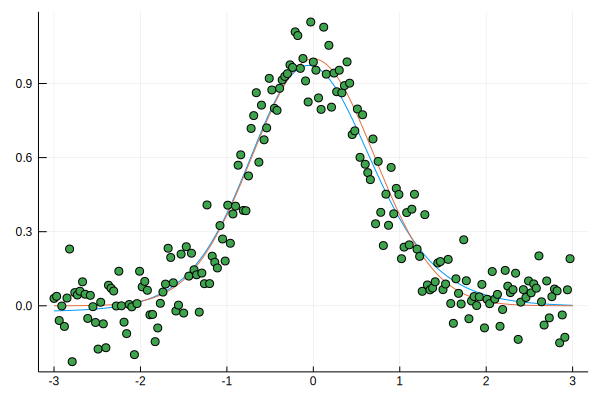

In [16]:
# Checking if the training worked. Compare the learned function with the actual gaussian
xplot=collect(-Range:0.01:Range)
# plot the converged function, the initial gaussian and the noisy training samples
plot(xplot,[predict(w,xplot)',exp.(-xplot.^2)]);
scatter!(x_train,y_train,leg=false)

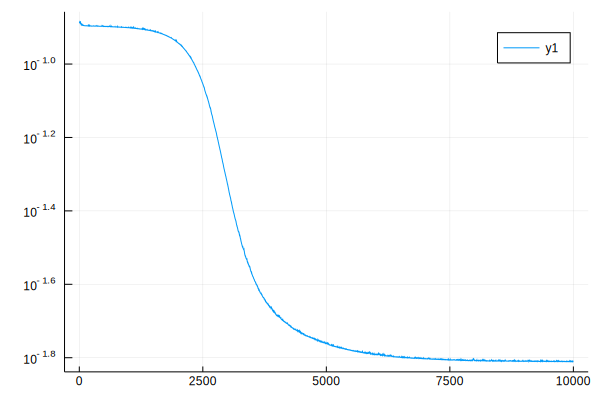

In [17]:
# Plot loss
SamplingRate=min(1,div(Nmarkov,1000));
x = collect(1:SamplingRate:Nmarkov);
y = [loss(w_training[:,i],x_train,y_train) for i in x];
#plot(x,y)
plot(x,y
#    ,xaxis=:log10
    ,yaxis=:log10
    ) # can also plot in log-log scale

## Diffusion, Hessian, Covariance Matrices

In [18]:
function diffusionmatrix(w,xt,yt,Nb,lr)
    Nweights = length(w) # number of weights, that is, dimensions of the diffusion tensor
    Nt = length(xt) # number of training examples to be summed over
    prefac = (Nt-Nb)/(2*Nb*(Nt-1))
    V = zeros(Nweights,Nt) # initialize the diffusion matrix
    for i=1:Nt
        x=xt[i]
        y=yt[i]
        V[:,i] = lossgradient(w,[x],[y])
    end
    V /= Nt;
    dL = sqlossgradient(w,xt,yt);
    
    return lr^2 * prefac * (Nt*V*V' - dL*dL')
end

diffusionmatrix (generic function with 1 method)

In [19]:
# Calculate the diffusion tensor by sampling the noise
function diffusionmatrix_num(w,n,lr) # n: number of samples used for estimation
    wlist = zeros(Nweights,n)
    
    for i=1:n
        ww = copy(w)       
        wlist[:,i] = batchtrain!(ww,lr)
    end

    # subtract mean
    wlist .-= sum(wlist[:,i] for i=1:n)/n

    D = zeros(Nweights,Nweights)
    for α=1:Nweights
        for β=1:Nweights
            for i=1:n
                D[α,β] += wlist[α,i]*wlist[β,i]
            end
            D[α,β] /= n;
        end
    end
    return 0.5*D
end

diffusionmatrix_num (generic function with 1 method)

In [20]:
# To calculate the Hessian, define a scalar function returning ∂L/∂wⱼ
function lossgradj(w,x,y,j)
    return lossgradient(w,x,y)[j]
end

lossgradj (generic function with 1 method)

In [21]:
# Define the function returning ∂²L/∂wᵢ∂wⱼ for all i, given j (a column of the Hessian)
lossgradgrad = grad(lossgradj)

(::getfield(AutoGrad, Symbol("#gradfun#8")){getfield(AutoGrad, Symbol("##gradfun#6#7")){typeof(lossgradj),Int64,Bool}}) (generic function with 1 method)

In [22]:
function hessianmatrix(w,x,y)
    Nw = length(w);
    Hess = zeros(Nw,Nw);
    for j=1:Nw
        Hess[:,j] = lossgradgrad(w,x,y,j)
    end
    return Hess
end

hessianmatrix (generic function with 1 method)

In [23]:
# This calculation is from Michael's overleaf notes:
# https://www.overleaf.com/2523873322bvvnxpwnskfk
function covariancematrix(D,H,lr) # is a function of the learning rate
    F = eigen(H);
    h = F.values
    O = F.vectors
    Nw = length(h)
    ODO = O'*D*O;
    Delta = zeros(Nw,Nw);
    for i=1:Nw
        for j=1:Nw
            Delta[i,j] = ODO[i,j]/(h[i]+h[j])
        end
    end
    return (2/lr)*O*Delta*O'
end

covariancematrix (generic function with 1 method)

### Use Newton's Method to find the minimum of loss

In [24]:
# Using Newton's method get the the true minimum of the full loss function
w = w_training[:,end];
# implement Newton's method to find the true minimum. 4 steps are enough!
for n=1:10
    Hess = hessianmatrix(w,x_train,y_train)
    gradw = lossgradient(w,x_train,y_train)
    dw = inv(Hess)*gradw
    for i=1:Nweights
        w[i] -= dw[i]
    end
end
wmin = w[:,1]

7-element Array{Float64,1}:
  1.2863560700651808  
  1.1850177733330083  
  0.7216320599019037  
 -0.5095749741748058  
  0.9184498728752972  
 -0.9027273944837443  
 -0.010323317556957813

In [25]:
lossgradient(wmin,x_train,y_train)

7-element Array{Float64,1}:
 -1.734723475976807e-17 
  1.474514954580286e-17 
  1.4094628242311558e-17
  9.540979117872439e-18 
 -2.211772431870429e-17 
 -3.122502256758253e-17 
 -3.3949080525952358e-18

### Hessian at the loss minimum

In [26]:
Hessmin = hessianmatrix(wmin,x_train,y_train)

7×7 Array{Float64,2}:
  0.157375   -0.0458678  -0.17051       0.017018     0.179116      0.289186    -0.264274
 -0.0458678   0.131955    0.017018      0.135184    -0.282683     -0.207121    -0.214834
 -0.17051     0.017018    0.301226     -0.169161    -0.000764286  -0.323432     0.475083
  0.017018    0.135184   -0.169161      0.313604    -0.3449       -8.81505e-5  -0.506524
  0.179116   -0.282683   -0.000764286  -0.3449       1.48473       1.21482      0.363552
  0.289186   -0.207121   -0.323432     -8.81505e-5   1.21482       1.4409      -0.296098
 -0.264274   -0.214834    0.475083     -0.506524     0.363552     -0.296098     2.002   

In [27]:
eigvals(Hessmin), norm(Hessmin)

([2.82052, 2.47078, 0.306216, 0.183353, 0.0396308, 0.00577055, 0.00551459], 3.76684645818456)

### Diffusion tensor at the loss minimum

In [28]:
# diffusion tensor at the loss minimum (using VV')
Dmin = diffusionmatrix(wmin,x_train,y_train,Batchsize,η)

7×7 Array{Float64,2}:
  1.67937e-8  -5.11246e-9  -1.78646e-8   1.38112e-9   1.9996e-8    3.10604e-8  -2.80752e-8
 -5.11246e-9   1.428e-8     1.32342e-9   1.54304e-8  -2.98171e-8  -2.07007e-8  -2.27774e-8
 -1.78646e-8   1.32342e-9   2.90767e-8  -1.64208e-8  -1.84981e-9  -3.30232e-8   4.82712e-8
  1.38112e-9   1.54304e-8  -1.64208e-8   3.26251e-8  -3.65189e-8  -1.2848e-9   -5.26565e-8
  1.9996e-8   -2.98171e-8  -1.84981e-9  -3.65189e-8   1.36906e-7   1.10056e-7   2.8007e-8 
  3.10604e-8  -2.07007e-8  -3.30232e-8  -1.2848e-9    1.10056e-7   1.31134e-7  -3.87722e-8
 -2.80752e-8  -2.27774e-8   4.82712e-8  -5.26565e-8   2.8007e-8   -3.87722e-8   1.89495e-7

In [29]:
# compare with D calculated numerically
Dmin_num = diffusionmatrix_num(wmin,10000,η);
Dmin_num ./ Dmin

7×7 Array{Float64,2}:
 0.99912   0.940512  0.99803   1.24354   1.01228   1.01319   1.02768 
 0.940512  0.994799  0.74584   1.00371   0.997254  0.984536  1.01157 
 0.99803   0.74584   0.99979   1.01964   0.969049  1.00302   1.00692 
 1.24354   1.00371   1.01964   1.00159   1.00034   0.896195  0.999298
 1.01228   0.997254  0.969049  1.00034   1.01438   1.01646   0.944145
 1.01319   0.984536  1.00302   0.896195  1.01646   1.01323   1.03515 
 1.02768   1.01157   1.00692   0.999298  0.944145  1.03515   0.997648

In [30]:
@show isapprox(Dmin_num,Dmin, rtol=0.01)
@show isapprox(Dmin_num,Dmin, rtol=0.02)

isapprox(Dmin_num, Dmin, rtol=0.01) = false
isapprox(Dmin_num, Dmin, rtol=0.02) = true


true

### Covariance matrix as a function of Hessian and Diffusion matrix

In [31]:
Covmin = covariancematrix(Dmin,Hessmin,η)

7×7 Array{Float64,2}:
  7.81618e-6   2.83268e-7  -2.23818e-6  -5.46876e-7   1.07632e-6  -6.1392e-7   -2.82746e-7
  2.83268e-7   8.11357e-6   4.01085e-7   1.92996e-6   6.99863e-7  -1.11193e-6  -3.26667e-7
 -2.23818e-6   4.01085e-7   6.33507e-6   5.92701e-7   1.72701e-6  -1.8211e-6    2.59965e-7
 -5.46876e-7   1.92996e-6   5.92701e-7   6.5342e-6   -2.40035e-6   2.06748e-6  -4.62624e-7
  1.07632e-6   6.99863e-7   1.72701e-6  -2.40035e-6   6.73593e-6   2.40204e-6  -1.37624e-7
 -6.1392e-7   -1.11193e-6  -1.8211e-6    2.06748e-6   2.40204e-6   6.49792e-6  -6.44694e-7
 -2.82746e-7  -3.26667e-7   2.59965e-7  -4.62624e-7  -1.37624e-7  -6.44694e-7   9.14381e-6

In [32]:
# verify that the math is right: HC+CH = (2/η)D
norm(Hessmin*Covmin + Covmin*Hessmin - (2/η)*Dmin) # should be zero

9.924173799576777e-20

## Steady state

In [33]:
Random.seed!(1)
Nmarkov = 10^7; # number of Markov steps

In [34]:
w = copy(wmin); # start from the minimum of the potential

In [35]:
fname = "Gaussian_wr_ss-$Nmarkov-$η.jld2"
if !isfile(fname)
    w_ss = zeros(Nweights,Nmarkov)
    time0 = time() # takes about an hour for Nmarkov = 10^7
    for n = 1:Nmarkov
        w_ss[:,n] = batchtrain!(w,η)
    end
    @show time()-time0
    Knet.save(fname, "w_ss", w_ss)
    else
        w_ss = Knet.load(fname, "w_ss");
    end
@show summary(w_ss)

summary(w_ss) = "7×10000000 Array{Float64,2}"


"7×10000000 Array{Float64,2}"

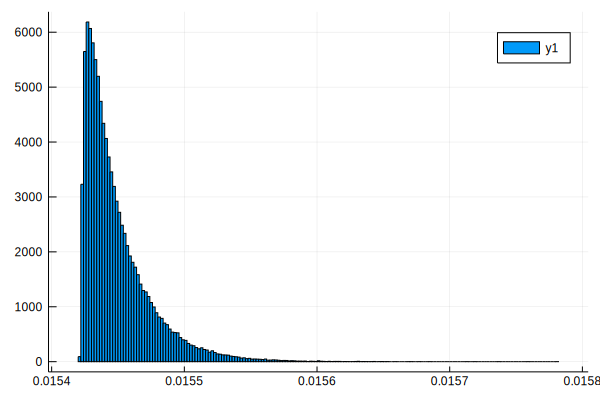

In [36]:
Nhist=10^5
skip = div(Nmarkov,Nhist)
trajloss = zeros(Nhist)
for n=1:Nhist
    trajloss[n] = loss(w_ss[:,n*skip],x_train,y_train)
end
histogram(trajloss)

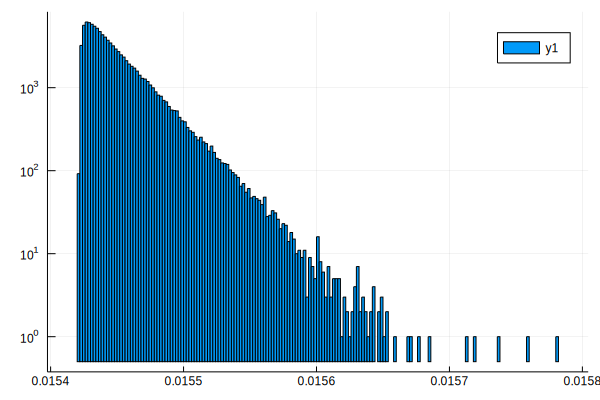

In [37]:
histogram(trajloss,yaxis=:log)

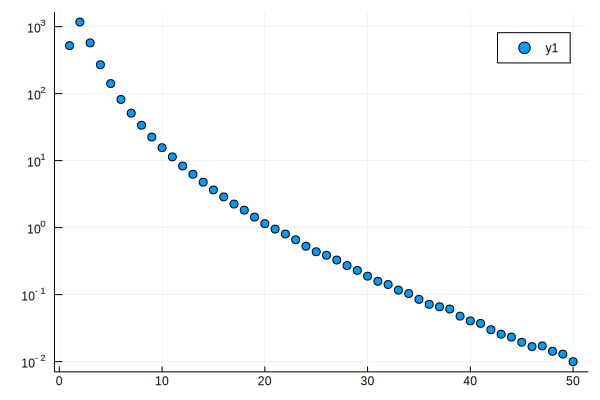

In [38]:
fith = fit(Histogram,trajloss,nbins=200)
my_y = fith.weights # bin counts
my_x = collect(1:length(my_y))
y = my_y[1:end] ./ ((my_x.-0.5)[1:end].^2.5)
y .+= 1e-10
scatter(y[1:50],yaxis=:log)

### Fit a Mv-Gaussian to the equilibrium data

In [39]:
Fit_ss = fit_mle(MvNormal,w_ss)

FullNormal(
dim: 7
μ: [1.28659, 1.185, 0.72205, -0.509812, 0.918041, -0.902316, -0.0103062]
Σ: [7.36541e-6 3.36126e-7 … -5.10219e-7 -2.96368e-7; 3.36126e-7 7.91925e-6 … -1.16729e-6 -3.25431e-7; … ; -5.10219e-7 -1.16729e-6 … 6.56006e-6 -6.67475e-7; -2.96368e-7 -3.25431e-7 … -6.67475e-7 9.27504e-6]
)


### Steady-state mean


In [40]:
wmean = Distributions.mean(Fit_ss)

7-element Array{Float64,1}:
  1.2865894047547268  
  1.1850043210377585  
  0.7220497299931339  
 -0.5098122231702785  
  0.918041012941426   
 -0.9023163365760021  
 -0.010306188349074387

In [41]:
norm(wmean-wmin)/norm(wmin)

0.0003362951200872646

### Covariance matrix (from ss-trajectory)

In [42]:
Cov_ss = Distributions.cov(Fit_ss)

7×7 Array{Float64,2}:
  7.36541e-6   3.36126e-7  -2.33575e-6  -6.41977e-7   1.01328e-6  -5.10219e-7  -2.96368e-7
  3.36126e-7   7.91925e-6   5.27349e-7   1.97085e-6   7.27997e-7  -1.16729e-6  -3.25431e-7
 -2.33575e-6   5.27349e-7   6.1838e-6    4.14821e-7   1.74016e-6  -1.81144e-6   2.61679e-7
 -6.41977e-7   1.97085e-6   4.14821e-7   6.35546e-6  -2.40279e-6   2.09418e-6  -4.62711e-7
  1.01328e-6   7.27997e-7   1.74016e-6  -2.40279e-6   6.81396e-6   2.47635e-6  -1.50289e-7
 -5.10219e-7  -1.16729e-6  -1.81144e-6   2.09418e-6   2.47635e-6   6.56006e-6  -6.67475e-7
 -2.96368e-7  -3.25431e-7   2.61679e-7  -4.62711e-7  -1.50289e-7  -6.67475e-7   9.27504e-6

In [43]:
# Compare with the solution of ΣH + HΣ = (2/η)D
norm(Covmin-Cov_ss)/norm(Covmin)

0.033762789991018255

### Visualize the steady-state distribution

In [44]:
# weight indices to visualize
xid,yid = Nweights,Nweights-1

(7, 6)

In [45]:
ss_range=collect(1:Nmarkov) # may want to leave out a transient 
wx = w_ss[xid,ss_range]
wy = w_ss[yid,ss_range]
resxy=(200,200) # histogram bins

# Extract histogram data
fith = fit(Histogram,(wx,wy),nbins=resxy)
fith.weights # bin counts
fith.edges # bin boundaries
maxhist=maximum(fith.weights); # will use later for better looking plots

In [46]:
# Construct a grid enclosing the steady-state trajectory
minmaxdiff(t) = maximum(t)-minimum(t)

function makegrid(xvec,yvec,mean,xindex,yindex;Nx=50,Ny=50,zoom=0.7)
    Lx,Ly = minmaxdiff(xvec)/2.0,minmaxdiff(yvec)/2.0
    xrange,yrange = zoom*Lx,zoom*Ly
    dx,dy = xrange/Nx,yrange/Ny
    x = collect(-xrange:dx:xrange) .+ mean[xindex]
    y = collect(-yrange:dy:yrange) .+ mean[yindex]

    # some mumbo-jumbo for calculating weights corresponding to grid points
    Identity = Diagonal(ones(Nweights,Nweights)); # unit matrix
    xmask = Identity[:,xindex];
    ymask = Identity[:,yindex];
    Imask = Identity - xmask*xmask' - ymask*ymask' # set two diagonal elements to zero
    return (x,y,Imask,xmask,ymask,[x[1],x[end]],[y[1],y[end]])
end

(x,y,Imask,xmask,ymask,xrange,yrange) = makegrid(wx,wy,wmean,xid,yid);

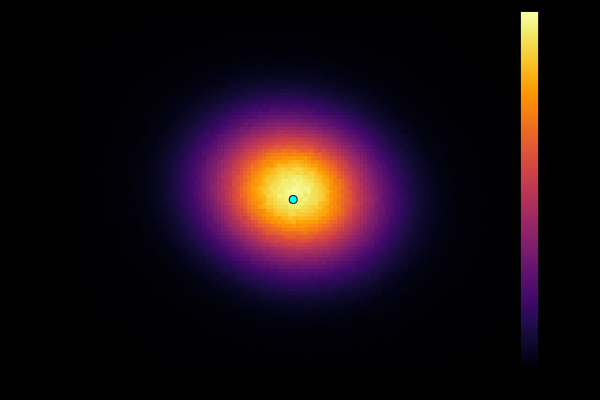

In [47]:
histogram2d(wx,wy
    ,bins=resxy
    ,xlim=xrange
    ,ylim=yrange
)
scatter!([wmin[xid]],[wmin[yid]]
    ,aspect_ratio=1.0
    ,leg=false # no legend
    ,markercolor="cyan"
    ,markersize=4
    ,background_color="black"
    ) # loss minimum

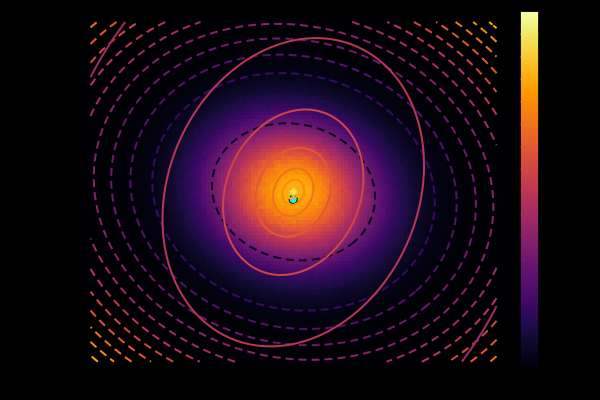

┌ Warning: Overwriting colorbar entry
└ @ Plots /home/ec2-user/.julia/packages/Plots/oiirH/src/backends/gr.jl:438


In [48]:
# overlay loss and isoprobability contours

meanxy = wmean[[xid yid]]

# 2x2 submatrix corresponding to the inverse covariance for the marginal distribution p(xid,yid)
Cov_xy_inv = inv(Cov_ss[[xid,yid],[xid,yid]])

## mv-Gaussian fit contours
fexp(s,t) = -(([s t]-meanxy)*Cov_xy_inv*([s t]-meanxy)')[1]
ffit(s,t) =  maxhist * fexp(s,t)/fexp(x[end],y[end])
contour!(x,y,ffit # "!" draws on top of the previous plot
    ,linestyle=:dash
    ,linewidth=2)

## Loss contours
midx = Int((length(x)-1)/2)
midy = Int((length(y)-1)/2)
fexp(s,t) = loss(Imask*wmean + s*xmask + t*ymask,x_train,y_train) - loss(wmin,x_train,y_train)
flossxy(s,t) = maxhist * log(fexp(s,t))/log(fexp(x[midx],y[midy]))
contour!(x,y,flossxy,linewidth=2)

### Move to the eigen-coordinates

In [49]:
# pick two eigen directions
Xid,Yid = Nweights,Nweights-1
O = eigvecs(Cov_ss);
Λ = eigvals(Cov_ss);

W_ss = O'*w_ss; # sample weights are row vectors
Wx = W_ss[Xid,:]
Wy = W_ss[Yid,:]

COV_ss = O'*Cov_ss*O # by construction diagonal
COV_xy_inv = inv(COV_ss[[Xid,Yid],[Xid,Yid]]) # this must be Diag(λx,λy)

Wmean = O'*wmean
Wmin = O'*wmin;

In [50]:
# COV_xy_inv = Diag(λx,λy)
norm(COV_xy_inv - Diagonal([1/Λ[Xid],1/Λ[Yid]]))

5.214702937753598e-11

### Visualize in the eigenspace

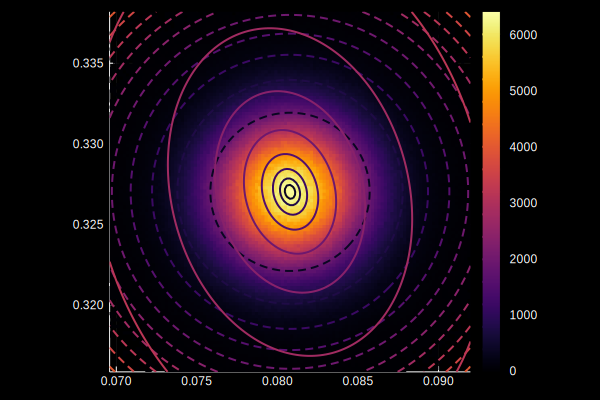

┌ Warning: Overwriting colorbar entry
└ @ Plots /home/ec2-user/.julia/packages/Plots/oiirH/src/backends/gr.jl:438


In [51]:
(x,y,Imask,xmask,ymask,xrange,yrange) = makegrid(Wx,Wy,Wmin,Xid,Yid;Nx=60,Ny=60)
histogram2d(Wx,Wy
    ,bins=resxy
    ,aspect_ratio=1
    ,background_color="black"
    ,xlim=xrange
    ,ylim=yrange
)

meanXY = Wmin[[Xid Yid]]
# Contours of the fit mv-Gaussian
fexp(s,t) = -(([s t]-meanXY)*COV_xy_inv*([s t]-meanXY)')[1]
Ffit(s,t) = (maxhist/2)* fexp(s,t)/fexp(x[end],y[end])
contour!(x,y,Ffit,
    linestyle=:dash,
#     levels=75,
    linewidth=2)

# contours of loss
midx = Int((length(x)-1)/2)
midy = Int((length(y)-1)/2)
fexp(s,t) = loss(O*(Imask*Wmin + s*xmask + t*ymask),x_train,y_train) - loss(wmin,x_train,y_train)
Flossxy(s,t) =  (maxhist/20)*log((fexp(s,t)/fexp(x[midx],y[midy]))+1)
contour!(x,y,Flossxy,
    linewidth=2)

## Probability current

In [52]:
# Function that calculates the probability current at a given w
# again, from Michael's notes.

# Note that, current is calculated in the original weight space

function currentvec(w,w0,H,Σ,D,lr)
    dw = w-w0;
    return (D*inv(Σ) - lr*H)*dw 
end

currentvec (generic function with 1 method)

### Visualize the probability current vector field

In [53]:
# scan the vicinity of ss-distribution's mean (center point of the grid) to 
# get a sense of the current vector field. Two components are scanned while
# the rest are fixed to their value at the mean.

function gridarray(wcenter,x_index,y_index,Nx,Ny,Lx,Ly)
    warray = zeros(Nweights,(Nx+1)*(Ny+1))
    for nx=0:Nx
        for ny=0:Ny
            dw = wcenter-wcenter # keep data structure, fill with zeros
            dw[x_index] = -Lx + 2*Lx*nx/Nx
            dw[y_index] = -Ly + 2*Ly*ny/Ny
            warray[:,1+nx*(Ny+1)+ny] = wcenter + dw
        end
    end
    return warray
end


gridarray (generic function with 1 method)

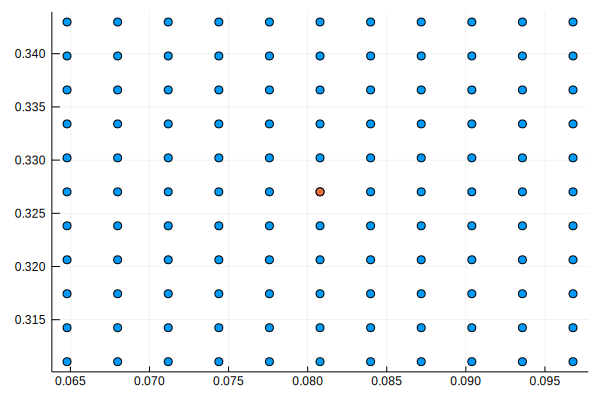

In [54]:
Lx = minmaxdiff(Wx)/2
Ly = minmaxdiff(Wy)/2
Nx = Ny = 10
# Construct a grid in the (Xid,Yid) eigen-plane
Warray = gridarray(Wmin,Xid,Yid,Nx,Ny,Lx,Ly)

# Scatter plot of weight values. wstar is shown in red
scatter(Warray[Xid,:],Warray[Yid,:]); scatter!([Wmin[Xid]],[Wmin[Yid]],leg=false)

In [55]:
# Calculate current vectors.
# Need to back transform the Warray points on the eigen-plane to the original weight basis
# using (O*warray), since currentvec() is calculated from the original weights.
# The current vectors are then transformed to the eigenbasis using O'*currentvec()

npts = length(Warray[1,:])
currents = zeros(Nweights,npts)
for i=1:npts
    currents[:,i] = O'*currentvec(O*Warray[:,i],wmin,Hessmin,Covmin,Dmin,η)
end
currents

7×121 Array{Float64,2}:
  6.45762e-8   6.08361e-8   5.7096e-8    5.33559e-8  …  -5.33559e-8  -5.7096e-8   -6.08361e-8  -6.45762e-8
  1.63237e-6   1.6326e-6    1.63283e-6   1.63306e-6     -1.63306e-6  -1.63283e-6  -1.6326e-6   -1.63237e-6
 -1.30592e-5  -1.01611e-5  -7.26286e-6  -4.36467e-6      4.36467e-6   7.26286e-6   1.01611e-5   1.30592e-5
  1.47086e-6   2.26812e-6   3.06538e-6   3.86264e-6     -3.86264e-6  -3.06538e-6  -2.26812e-6  -1.47086e-6
 -1.75238e-6  -6.16228e-7   5.19922e-7   1.65607e-6     -1.65607e-6  -5.19922e-7   6.16228e-7   1.75238e-6
  2.61415e-7   3.03282e-7   3.4515e-7    3.87017e-7  …  -3.87017e-7  -3.4515e-7   -3.03282e-7  -2.61415e-7
 -4.4144e-7   -3.75523e-7  -3.09605e-7  -2.43688e-7      2.43688e-7   3.09605e-7   3.75523e-7   4.4144e-7 

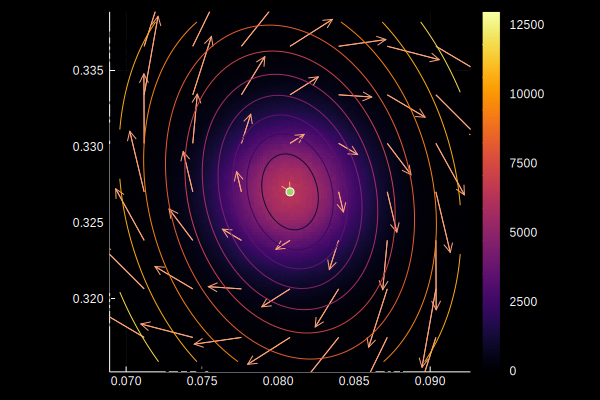

In [56]:
# plot the current vector field
histogram2d(Wx,Wy
    ,bins=200
    ,aspect_ratio=1
    ,background_color="black"
    ,xlim=xrange
    ,ylim=yrange
)

x = Warray[Xid,:];
y = Warray[Yid,:];
mynorm = 3*sqrt(4*Lx*Ly/(Nx*Ny))/maximum(abs.(currents[[Xid Yid],:]))
u_cur = mynorm*currents[Xid,:];
v_cur = mynorm*currents[Yid,:];


quiver!(x, y, quiver=(u_cur, v_cur));
scatter!([Wmin[Xid]],[Wmin[Yid]],leg=false)

(xx,yy,Imask,xmask,ymask) = makegrid(Wx,Wy,Wmin,Xid,Yid)
meanXY = Wmin[[Xid Yid]]
midx = div(length(xx),2)
midy = div(length(yy),2)
fexp(s,t) = loss(O*(Imask*Wmin + s*xmask + t*ymask),x_train,y_train) - loss(wmin,x_train,y_train)
Flossxy(s,t) =  0.5*maxhist*log((fexp(s,t)/fexp(x[midx],y[midy]))+1) # prefactor is to get the color scale right

# contours of loss
contour!(xx,yy,Flossxy,levels=10)

In [57]:
# Takes time (calculates the current field in all eigen-planes)
m = @manipulate for xind in slider(1:7,value=7), yind in slider(1:7,value=5)
    zoom=0.35
    Wxx = W_ss[xind,1:end]
    Wyy = W_ss[yind,1:end]
    Lx = zoom*minmaxdiff(Wxx)/2
    Ly = zoom*minmaxdiff(Wyy)/2
    Nx = Ny = 10
    Warr = gridarray(Wmin,xind,yind,Nx,Ny,Lx,Ly)
    npts = length(Warr[1,:])
    currents = zeros(Nweights,npts)
    for i=1:npts
        currents[:,i] = O'*currentvec(O*Warr[:,i],wmin,Hessmin,Covmin,Dmin,η)
    end
    x = Warr[xind,:];
    y = Warr[yind,:];
    mynorm = 3*sqrt(4*Lx*Ly/(Nx*Ny))/maximum(abs.(currents[[xind yind],:]))
    u_cur = mynorm*currents[xind,:];
    v_cur = mynorm*currents[yind,:];
    deltax = 0.2*minmaxdiff(Wxx)
    deltay = 0.2*minmaxdiff(Wyy)
    xmin=Wmin[xind]-deltax
    xmax=Wmin[xind]+deltax
    ymin=Wmin[yind]-deltay
    ymax=Wmin[yind]+deltay
    histogram2d(Wxx,Wyy
        ,bins=resxy
        ,aspect_ratio=1.0
        ,background_color="black"
        ,xlim=[xmin,xmax]
        ,ylim=[ymin,ymax]     
    )
    quiver!(x, y, quiver=(u_cur, v_cur));
    scatter!([Wmin[xind]],[Wmin[yind]],leg=false)
    
(xx,yy,Imask,xmask,ymask) = makegrid(Wxx,Wyy,Wmin,Xid,Yid;Nx=60,Ny=60)
     midx = div(length(x),2)
     midy = div(length(y),2)
     fexp(s,t) = loss(O*(Imask*Wmin + s*xmask + t*ymask),x_train,y_train) - loss(wmin,x_train,y_train)
     Flossxy(s,t) =  0.5*maxhist*log((fexp(s,t)/fexp(x[midx],y[midy]))+1)
     contour!(x,y,Flossxy,
     linewidth=2)
end

┌ Warning: Accessing `scope.id` is deprecated, use `scopeid(scope)` instead.
│   caller = ip:0x0
└ @ Core :-1


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>7,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Int64} with 2 listeners. Value:
7, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/ec2-user/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/ec2-user/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/ec2-user/.julia/packages/InteractBase/l8cEC/src/../assets/all.js"), Asset("css", nothing, "/home/ec2-user/.julia/packages/InteractBase/l8cEC/src/../assets/style.css"), Asset("css", nothing, "/home/ec2-user/.julia/packages/Interact/0klKX/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"11403824104892152748\",\"id\":\"ob_02\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"11403824104892152748\",\"id\":\"ob_01\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el

points not sorted in ascending order
points not sorted in ascending order


### Moving along the current vector field in 3d

In [58]:
Random.seed!(1)
w = wmean + 0.002*rand(Nweights)
Nsteps = 10000;
cur_traj = zeros(Nweights,Nsteps)

for t=1:Nsteps
    cur_traj[:,t] = w
    w += currentvec(w,wmean,Hessmin,Covmin,Dmin,η)
end
cur_eigtraj = O'* cur_traj;

In [59]:
@manipulate for θ in slider(0:10:90,value=20), ϕ in slider(0:10:90,value=60)
    plot3d(cur_eigtraj[end-1,:],cur_eigtraj[end-2,:],cur_eigtraj[end-4,:],camera=(θ,ϕ))
end
#plot(cur_eigtraj[end-3,:],cur_eigtraj[end-2,:])

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>10,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Any} with 2 listeners. Value:
3, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/home/ec2-user/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/ec2-user/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/ec2-user/.julia/packages/InteractBase/l8cEC/src/../assets/all.js"), Asset("css", nothing, "/home/ec2-user/.julia/packages/InteractBase/l8cEC/src/../assets/style.css"), Asset("css", nothing, "/home/ec2-user/.julia/packages/Interact/0klKX/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:9223372036854775807,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0\",\"10\",\"20\",\"30\",\"40\",\"50\",\"60\",\"70\",\"80\",\"90\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"15047928708600820560\",\"id\":\"ob_13\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"15047928708600820560\",\"id\":\"ob_12\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableAr

## Rotation

In [60]:
function arealvelocity(traj,x,y,center)
    N = length(traj[1,:]) # trajectory length
    Area=zeros(N-1);
    Areasum=0
    for n=1:N-1
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[x,n]-center[x],traj[y,n]-center[y],0]
        v2=[traj[x,n+1]-center[x],traj[y,n+1]-center[y],0]
        Areasum += cross(v1,v2)[3] # this is twice the area of the triangle
    end
    return Areasum/(2*(N-1))
end

fname = "Gaussian_wr_arealvelocity_$Nmarkov.jld2"
if !isfile(fname)
    Av = zeros(Nweights,Nweights)
    time0 = time() # takes about 11 minutes for Nmarkov = 10^7
    for i = 1:Nweights-1
        for j = i+1:Nweights # av is antisymmetric
            Av[i,j] = arealvelocity(W_ss,i,j,Wmean)
            Av[j,i] = -Av[i,j]
        end
    end
    Av /= η^2
    @show time()-time0
    
    Knet.save(fname, "Av", Av)
else
    Av = Knet.load(fname, "Av");
end

7×7 Array{Float64,2}:
  0.0         -2.66441e-8   1.11463e-6   2.40649e-7  -7.4413e-7    2.09093e-7   3.05892e-7
  2.66441e-8   0.0          4.34496e-7   1.41342e-6  -7.14816e-7  -1.13005e-7   9.71212e-6
 -1.11463e-6  -4.34496e-7   0.0          1.35781e-5   2.9341e-5   -8.98832e-5   9.38161e-6
 -2.40649e-7  -1.41342e-6  -1.35781e-5   0.0          7.85405e-6  -2.53274e-5   3.41314e-5
  7.4413e-7    7.14816e-7  -2.9341e-5   -7.85405e-6   0.0         -3.54486e-5   2.71997e-5
 -2.09093e-7   1.13005e-7   8.98832e-5   2.53274e-5   3.54486e-5   0.0         -1.80047e-6
 -3.05892e-7  -9.71212e-6  -9.38161e-6  -3.41314e-5  -2.71997e-5   1.80047e-6   0.0       

In [61]:
# (HΣ-ΣH)/2η may be better than (ηHΣ-D)/η² numerically,
# since it is antisymmetric by construction.
# Alternatively, once can substitute Σ(H₀,D₀), solution of the Lyapunov equation, for Σ
# if the values of H and D are more reliable.

#Av_theo = O'*(η*Hessmin*Covmin - Dmin)*O/η^2
Av_theo = O'*(η/2)*(Hessmin*Cov_ss - Cov_ss*Hessmin)*O/η^2

7×7 Array{Float64,2}:
  5.96359e-21  -2.16257e-9    9.32483e-7    1.40796e-7   -7.76879e-7    1.43426e-7  1.27198e-7 
  2.16257e-9    4.64516e-21   1.23133e-6    2.32067e-6   -6.51404e-8   -1.69031e-7  1.10536e-5 
 -9.32483e-7   -1.23133e-6   -2.90717e-20   1.28551e-5    2.79369e-5   -8.4008e-5   1.27844e-5 
 -1.40796e-7   -2.32067e-6   -1.28551e-5   -8.04857e-21   7.16789e-6   -2.42568e-5  2.71195e-5 
  7.76879e-7    6.51404e-8   -2.79369e-5   -7.16789e-6   -5.61309e-21  -3.18286e-5  2.08561e-5 
 -1.43426e-7    1.69031e-7    8.4008e-5     2.42568e-5    3.18286e-5    2.3324e-20  2.00401e-6 
 -1.27198e-7   -1.10536e-5   -1.27844e-5   -2.71195e-5   -2.08561e-5   -2.00401e-6  3.19383e-20

In [62]:
@show 2*norm(Av-Av_theo)/(norm(Av)+norm(Av_theo))
@show std(Av), std(Av_theo), std(Av-Av_theo);

(2 * norm(Av - Av_theo)) / (norm(Av) + norm(Av_theo)) = 0.11871790158859485
(std(Av), std(Av_theo), std(Av - Av_theo)) = (2.3433479021692366e-5, 2.1529470424883238e-5, 2.6689535037657646e-6)


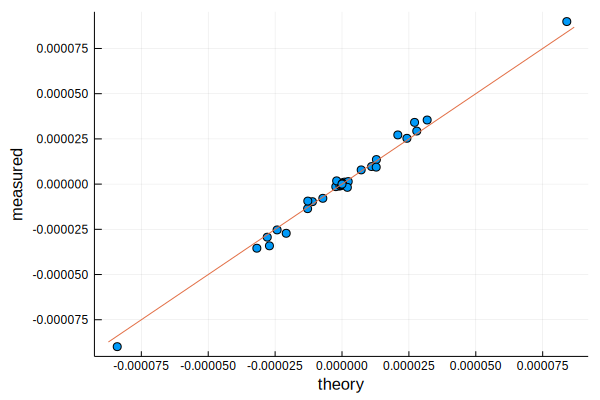

In [63]:
# Compare theory vs numerics for the areal velocity on each eigen-plane.
scatter(reshape(Av_theo,Nweights^2,1),reshape(Av,Nweights^2,1)
    ,leg=:false
)
g(x)=x
plot!(g,xlabel="theory",ylabel="measured")

In [64]:
# monitor the area swept during rotation
function area_vs_t(traj,x,y,center)
    N = length(traj[1,:])
    Area=zeros(N);
    Areasum=zeros(N);
    rad=0; # mean radius of the trajectory
    for n=2:N
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[x,n-1]-center[x],traj[y,n-1]-center[y],0]
        v2=[traj[x,n]-center[x],traj[y,n]-center[y],0]
        rad += norm(v2)
        # get the angle between them. Sign of Sinθ gives the direction
        Area[n] = cross(v1,v2)[3]/2
        Areasum[n] = Areasum[n-1]+Area[n]
    end
    
    return Areasum,rad/(N-1)
end

area_vs_t (generic function with 1 method)

In [65]:
#areaX = Nweights-4
#areaY = Nweights-2
# Look at the eigen-plane with maximal areal velocity
# or uncomment above to choose your own

@show areaX,areaY = Tuple(findmax(Av)[2])
rad = zeros(Nweights,Nweights); # mean radius of w projections for each eigenvector pair

(areaX, areaY) = Tuple((findmax(Av))[2]) = (6, 3)


In [66]:
@time area,rad[areaX,areaY] = area_vs_t(W_ss[:,1:10:end],areaX,areaY,Wmean);

  3.855133 seconds (15.23 M allocations: 682.904 MiB, 13.56% gc time)


In [67]:
np = length(area)
nskip = div(np,1000)
x = collect(1:1000);
orbit_area = π*rad[areaX,areaY]^2

4.460078069122528e-5

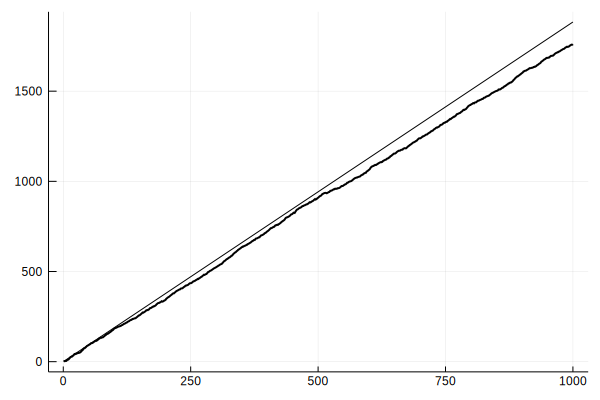

In [68]:
plot(x,area[1:nskip:end]/orbit_area,leg=false,linewidth=2,linecolor="black")
plot!(x*Av_theo[areaX,areaY]/orbit_area,linecolor="black")

### Rotation analysis by Fourier transform

In [69]:
W_ss

7×10000000 Array{Float64,2}:
  0.064741    0.064746    0.0647436   0.0647428   0.0647382  …   0.065402    0.065411    0.0654139   0.065407 
  0.462845    0.46284     0.462838    0.462835    0.462829       0.465416    0.465443    0.465454    0.465489 
 -0.087827   -0.0874093  -0.0876499  -0.08711    -0.0876427     -0.0878923  -0.0883952  -0.0882458  -0.0889247
  2.00433     2.00451     2.00433     2.00458     2.00408        2.00975     2.00947     2.00953     2.00927  
 -1.06818    -1.06802    -1.06829    -1.0679     -1.06876       -1.06614    -1.06618    -1.06599    -1.06566  
  0.327354    0.326874    0.326971    0.32607     0.326451   …   0.328221    0.328293    0.328341    0.328469 
  0.0809241   0.0803976   0.078489    0.0782578   0.0764194      0.0767732   0.0768132   0.076818    0.077133 

In [70]:
using FFTW

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %>               ]  60.3 %=====================================>   ]  90.5 % Resolving package versions...
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
 [no changes]


In [71]:
Wfft = fft(W_ss[end,:])

10000000-element Array{Complex{Float64},1}:
   807788.2297480033 + 0.0im               
 -161.04754978021913 - 190.33262957504374im
   88.01786918895814 - 12.880358930838245im
   14.43775005443836 + 44.164899607939994im
   93.34342244633295 + 179.5961462430023im 
  -22.75794002153306 + 68.79303071573521im 
   56.79039279245903 + 146.67449542541337im
  -57.16070387937886 - 20.211050899825718im
  -67.88503543866067 - 140.17877557100422im
  -67.40839521185715 - 32.888279246241574im
 -125.68056194588802 - 64.32333656970255im 
 -15.787677935792587 - 141.21501589475608im
 -136.76464853561626 + 83.22657059502988im 
                     ⋮                     
 -136.76464853561623 - 83.22657059502987im 
 -15.787677935792601 + 141.21501589475605im
 -125.68056194588803 + 64.32333656970255im 
  -67.40839521185718 + 32.88827924624157im 
  -67.88503543866062 + 140.17877557100417im
  -57.16070387937883 + 20.21105089982571im 
  56.790392792459045 - 146.67449542541334im
  -22.75794002153303 - 68.793030

In [72]:
scatter(abs.(real(Wfft[10:1000:end-10])),yaxis=:log)

In [73]:
function angulardisp(traj,x,y,center)
    N = length(traj[1,:]) # trajectory length
    angle=0
    for n=1:N-1
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[x,n]-center[x],traj[y,n]-center[y],0]
        v2=[traj[x,n+1]-center[x],traj[y,n+1]-center[y],0]
        angle += asin(cross(v1,v2)[3]/(norm(v1)*norm(v2))) # this is twice the area of the triangle
    end
    return angle
end


Ad = zeros(Nweights,Nweights) # angular displacement
time0 = time() # takes about 11 minutes for Nmarkov = 10^7
for i = 1:Nweights-1
    for j = i+1:Nweights # av is antisymmetric
        Ad[i,j] = angulardisp(W_ss,i,j,Wmean)
        Ad[j,i] = -Ad[i,j]
        end
end
@show time()-time0
Ad

time() - time0 = 758.6769480705261


7×7 Array{Float64,2}:
    0.0      -113.103     419.532     347.238   -712.874    -53.8413  -320.928
  113.103       0.0       -94.1683    252.828   -118.695    -21.6169  1509.49 
 -419.532      94.1683      0.0      1853.3     3732.69   -9099.7     1211.21 
 -347.238    -252.828   -1853.3         0.0     1223.7    -3399.51    3011.09 
  712.874     118.695   -3732.69    -1223.7        0.0    -3906.42    2988.73 
   53.8413     21.6169   9099.7      3399.51    3906.42       0.0     -137.498
  320.928   -1509.49    -1211.21    -3011.09   -2988.73     137.498      0.0  

In [74]:
Ad/2π

7×7 Array{Float64,2}:
   0.0      -18.0009     66.7705    55.2646  -113.457      -8.5691   -51.0773
  18.0009     0.0       -14.9873    40.2389   -18.8908     -3.44044  240.243 
 -66.7705    14.9873      0.0      294.962    594.075   -1448.26     192.77  
 -55.2646   -40.2389   -294.962      0.0      194.757    -541.048    479.23  
 113.457     18.8908   -594.075   -194.757      0.0      -621.727    475.672 
   8.5691     3.44044  1448.26     541.048    621.727       0.0      -21.8835
  51.0773  -240.243    -192.77    -479.23    -475.672      21.8835     0.0   

In [75]:
norm(Ad/2π)

2768.206752875916

In [76]:
eigvals(Ad/2π)

7-element Array{Complex{Float64},1}:
  7.815970093361102e-14 + 1888.3391931032215im
  7.815970093361102e-14 - 1888.3391931032215im
                    0.0 + 496.8147410098759im 
                    0.0 - 496.8147410098759im 
 -4.739041159989109e-15 + 0.0im               
  3.552713678800501e-15 + 137.2389093496249im 
  3.552713678800501e-15 - 137.2389093496249im 